<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 5th exercise: <font color="#C70039">Work with Robust Random Cut Forest (RRCF) algorithms for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   15.11.2022
* Name: Tobias Esser
* matriculation number: 11134729

<img src="https://docs.aws.amazon.com/sagemaker/latest/dg/images/RCF2.jpg" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

* <font color=red>Install the RRCF package per pip:_$ pip install rrcf_</font>

The codes of this exercise is based on the codebase of the following team:

_M. Bartos, A. Mullapudi, & S. Troutman, rrcf: Implementation of the Robust Random Cut Forest algorithm for anomaly detection on streams , in: Journal of Open Source Software, The Open Journal, Volume 4, Number 35. 2019_

---------------------

### <font color="ce33ff">DESCRIPTION</font>:
This notebook allows you for learning Amazon's Robust Random Cut Forest algorithm and its implementation for detecting anomalies. The Robust Random Cut Forest Algorithm for anomaly detection was invented by Guha et al. in 2016. Further reading can be found here (&rarr; <a href="http://proceedings.mlr.press/v48/guha16.pdf">paper</a>):

_S. Guha, N. Mishra, G. Roy, & O. Schrijvers, Robust random cut forest based anomaly detection on streams, in Proceedings of the 33rd International conference on machine learning, New York, NY, 2016 (pp. 2712-2721)_.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. take the three data sets from exercize 1 and apply the RRCF to them.
5. interpret the results in writing.
-----------------------------------------------------------------------------------

### Robust random cut trees (part I)
A RRCT can be instantiated from a point set. Points can also be added and removed from an RRCT.

In [1]:
import numpy as np
import rrcf

#### A (robust) random cut tree can be instantiated from a point set (n x d)

#### A random cut tree can also be instantiated with no points.
The points can be inserted and removed afterwards.

In [2]:
tree = rrcf.RCTree()

#Inserting points at index i
for i in range(6):
    x = np.random.randn(2)
    #print("x=",x)
    tree.insert_point(x, index=i)

print(tree)

#Deleting points at index i 
tree.forget_point(2)

print(tree)

─+
 ├───+
 │   ├───+
 │   │   ├───+
 │   │   │   ├───+
 │   │   │   │   ├──(5)
 │   │   │   │   └──(4)
 │   │   │   └──(1)
 │   │   └──(2)
 │   └──(3)
 └──(0)

─+
 ├───+
 │   ├───+
 │   │   ├───+
 │   │   │   ├──(5)
 │   │   │   └──(4)
 │   │   └──(1)
 │   └──(3)
 └──(0)



### Robust random cut trees (part II)
#### Anomaly score
The likelihood that a point is an outlier is measured by the so-called <font color=red>collusive displacement (CoDisp)</font> score: if including a new point significantly changes the model's complexity (i.e. bit depth), then that point is more likely to be an outlier.

As a rule of thumb:
* scores of max(abs(3 * stdev)) are ok
* higher scores are an indication of an outlier.

### Robust random cut trees (part III)
#### Batch anomaly detection
This example shows how a robust random cut forest can be used to detect outliers in a batch setting. As you already know, outliers correspond to a larger CoDisp score.

In [3]:
import numpy as np
import pandas as pd
import rrcf

### Robust random cut trees (part IV)
#### Streaming anomaly detection
This example shows how the algorithm can be used to detect anomalies in streaming time series data.

In [4]:
import numpy as np
import rrcf

# Generate a data set (sine wave with an anomaly inside)
n = 730
A = 50
center = 100
phi = 30
T = 2*np.pi/100
t = np.arange(n)
sin = A*np.sin(T*t-phi*T) + center
sin[235:255] = 80

# Set tree parameters
num_trees = 40
shingle_size = 4
tree_size = 256

# Construct again a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Insert streaming points into tree and compute anomaly score
# Use the "shingle" generator to create a rolling window
points = rrcf.shingle(sin, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

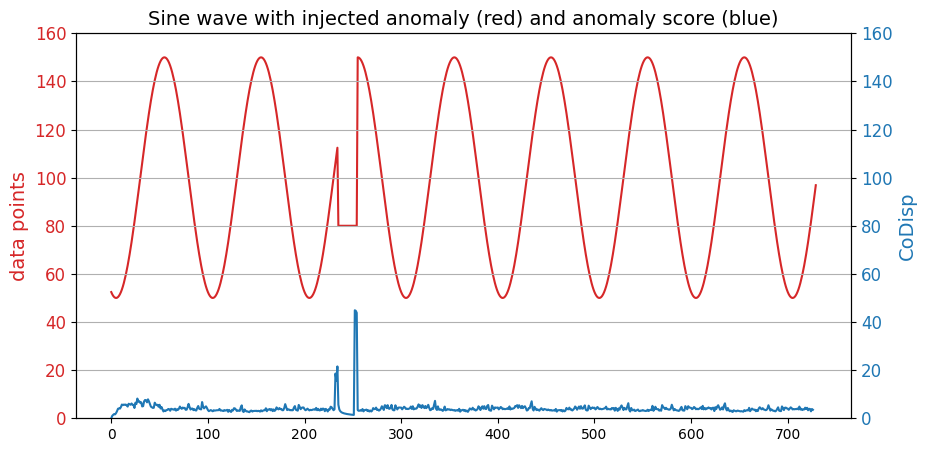

In [5]:
'''visualize the originil time series and the CoDisp score'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('data points', color=color, size=14)
ax1.plot(sin, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,160)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)
plt.show()

In [18]:
import numpy as np
import rrcf
import pandas as pd

# create the data set (sine wave with an anomaly inside)
df1 = pd.read_csv('data/loans_income.csv')
data1 = df1['x'].to_numpy()

# Set tree parameters
num_trees = 100
shingle_size = 20
tree_size = 256

# Construct again a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Insert streaming points into tree and compute anomaly score
# Use the "shingle" generator to create a rolling window
points = rrcf.shingle(data1, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

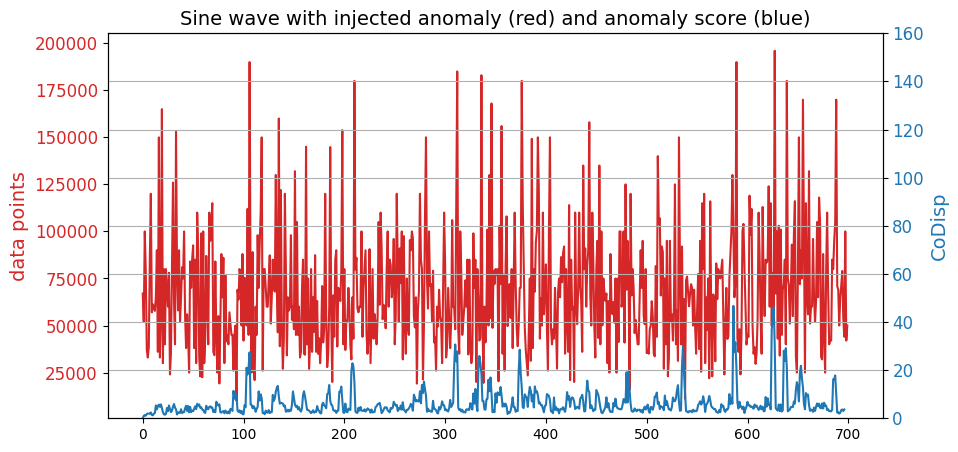

In [10]:
'''visualize the originil time series and the CoDisp score'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('data points', color=color, size=14)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)
plt.show()

In [ ]:
import numpy as np
import rrcf
import pandas as pd

# create the data set (sine wave with an anomaly inside)
df2 = pd.read_csv('data/SOCR-HeightWeight.csv')
data2 = df2['Height(Inches)'].to_numpy()

# Set tree parameters
num_trees = 100
shingle_size = 20
tree_size = 256

# Construct again a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Insert streaming points into tree and compute anomaly score
# Use the "shingle" generator to create a rolling window
points = rrcf.shingle(data2, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

In [ ]:
'''visualize the originil time series and the CoDisp score'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('data points', color=color, size=14)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)
plt.show()

In [ ]:
import numpy as np
import rrcf
import pandas as pd

# create the data set (sine wave with an anomaly inside)
df3 = pd.read_csv("https://userpage.fu-berlin.de/soga/200/2010_data_sets/students.csv")
data3 = df3[df3['gender'] == 'Female']["height"].to_numpy()

# Set tree parameters
num_trees = 100
shingle_size = 20
tree_size = 256

# Construct again a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Insert streaming points into tree and compute anomaly score
# Use the "shingle" generator to create a rolling window
points = rrcf.shingle(data3, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

In [ ]:
'''visualize the originil time series and the CoDisp score'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('data points', color=color, size=14)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)
plt.show()